<a href="https://colab.research.google.com/github/pikulsomesh/tutorials/blob/master/Demo_Colab_Tutorial_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install textdistance
!git clone https://github.com/learningmatter-mit/peptimizer

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
cd peptimizer

In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from utils.utils_synthesis.synthesis_feature_transformation import FeatureTransformation
from utils.utils_synthesis.synthesis_predictor import Predictor
from utils.utils_synthesis.synthesis_optimizer import Optimization
from utils.utils_common.activator import Activation

import pandas as pd

Specifying all paths and constants

In [ ]:
DATASET_PATH = './dataset/data_synthesis/synthesis_data.csv'
MINIMAL_MODEL_PATH = './model/model_synthesis/synthesis_minimal.hdf5'
PRE_CHAIN_SMILES_PATH = './dataset/data_synthesis/pre_chain_smiles.json'
AMINO_ACID_SMILES_PATH = './dataset/data_synthesis/amino_acid_smiles.json'
TRANSFORMATION_FUNCTIONS_PATH = './dataset/data_synthesis/transformation_function.pkl'
SCALING_FUNCTIONS_PATH = './dataset/data_synthesis/scaling_function.pkl'

FP_RADIUS = 3
FP_BITS = 128
SEQ_MAX = 50

MODEL_TYPE = 'complete'

#### Loading and Feature Transformation
Loads the data from a given *.csv file and transforms the features for training using the model <br>
Allows for specification of custom features and data types (categorical, continuous)<br>
Saves feature_transformation and scaling functions for ease of access during validation/prediction

In [ ]:
synthesis_data = pd.read_csv(DATASET_PATH)

In [ ]:
feature_transformation = FeatureTransformation(
    pre_chain_smiles_path = PRE_CHAIN_SMILES_PATH,
    amino_acid_smiles_path = AMINO_ACID_SMILES_PATH,
    model_type = MODEL_TYPE)

In [ ]:
nnX, nnY = feature_transformation.scale_transform(synthesis_data)

#### Training of model
Trains the model using transformed features and scaled labels <br>
Loads optimized hyperparameters and allows for custom parameters <br>
Saves checkpoints and trained models

In [ ]:
predictor = Predictor(MODEL_TYPE)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


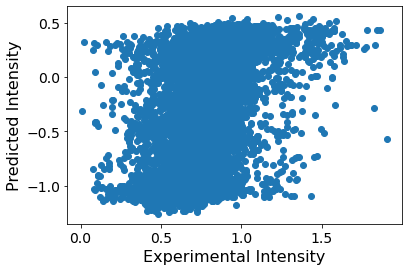

In [ ]:
predictor.train(nnX, nnY)

#### Gradient activation analysis
Allows for analysis of residues and positions which contribute the most to aggregation.

In [ ]:
# Sequence for demonstration

pre_chain = 'RQIKIWFQNRRMKWK' # From C-terminus to N-terminus
next_amino_acid = 'K'

In [ ]:
activator = Activation(
    mode = 'synthesis',
    model_path = MINIMAL_MODEL_PATH,
    fp_radius = FP_RADIUS,
    fp_bits = FP_BITS,
    seq_max = SEQ_MAX,
    pre_chain_smiles_path = PRE_CHAIN_SMILES_PATH,
    amino_acid_smiles_path = AMINO_ACID_SMILES_PATH,
    transformation_functions_path = TRANSFORMATION_FUNCTIONS_PATH,
    scaling_functions_path = SCALING_FUNCTIONS_PATH
)

Positive activation for feature map


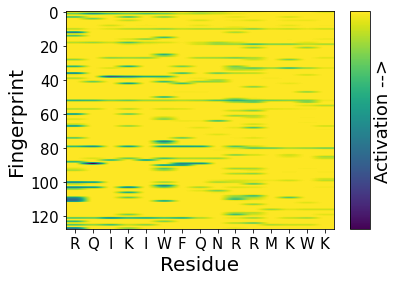

Positive activation averaged over residues


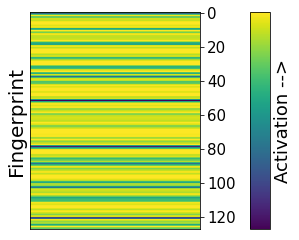

Positive activation averaged over fingerprints


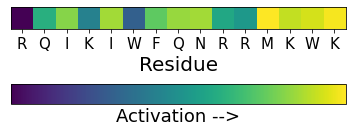

In [ ]:
activator.analyze(pre_chain + next_amino_acid)

#### Optimization
Optimizes a given sequence to reduce aggregation

In [ ]:
# Sequence for demonstration

pre_chain = 'RQIKIWFQNRRMKWK' # From C-terminus to N-terminus
next_amino_acid = 'K'

In [ ]:
optimize = Optimization(
    model_path = MINIMAL_MODEL_PATH,
    fp_radius = FP_RADIUS,
    fp_bits = FP_BITS,
    seq_max = SEQ_MAX,
    pre_chain_smiles_path = PRE_CHAIN_SMILES_PATH,
    amino_acid_smiles_path = AMINO_ACID_SMILES_PATH,
    transformation_functions_path = TRANSFORMATION_FUNCTIONS_PATH,
    scaling_functions_path = SCALING_FUNCTIONS_PATH
)

In [ ]:
df_optimize = optimize.optimize(pre_chain + next_amino_acid)

In [ ]:
# Difference in wild-type sequence
df_optimize[df_optimize['Mutation'] == 'WT']

,Mutant C-> N,Mutation,Difference
164,RQIKIWFQNRRMKWKK,WT,0.229068


In [ ]:
# Difference in single-point mutants
df_optimize.head()

,Mutant C-> N,Mutation,Difference
0,RQIKICFQNRRMKWKK,W11C,-0.580509
1,RQCKIWFQNRRMKWKK,I14C,-0.522296
2,RQIKINFQNRRMKWKK,W11N,-0.509592
3,RQICIWFQNRRMKWKK,K13C,-0.509221
4,RQIKIMFQNRRMKWKK,W11M,-0.494388
